# Phase 1 Data Cleansing from the source

In [3]:
SELECT * FROM 'hd_SPOTS.csv';

,ID,Parent ID,Is Complex,Square Space,Spot Type ID,Zip Code ID,Longitude,Updated At,Deleted At,User ID,Latitude,Created At,Zip Codes_ID,Zip Codes_State ID,Zip Codes_Municipality,Zip Codes_City
0,22536,None,0,"5,134",9,"67,634",99.22268290° W,"March 19, 2024, 8:48 PM",None,"8,524",19.46995870° N,"February 1, 2024, 11:14 AM",67634.0,15.0,Naucalpan de Juárez,Naucalpan de Juárez
1,22537,None,1,"1,121",11,"29,150",99.18854240° W,"April 17, 2024, 11:24 PM",None,"9,541",19.43216400° N,"February 1, 2024, 11:47 AM",29150.0,7.0,Miguel Hidalgo,Ciudad de México
2,22538,None,1,"3,950",11,"29,150",99.18601160° W,"April 17, 2024, 11:24 PM",None,"9,541",19.43194720° N,"February 1, 2024, 11:52 AM",29150.0,7.0,Miguel Hidalgo,Ciudad de México
3,22539,"22,538",0,"1,050",11,None,None,"April 17, 2024, 11:24 PM",None,"9,541",None,"February 1, 2024, 11:54 AM",NaN,NaN,None,None
4,22540,"22,538",0,"2,344",11,None,None,"April 17, 2024, 11:24 PM",None,"9,541",None,"February 1, 2024, 11:54 AM",NaN,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,27037,None,0,"8,892",15,"66,371",99.49251848° W,"May 3, 2024, 2:12 PM",None,"14,053",19.28549565° N,"April 30, 2024, 4:34 PM",66371.0,15.0,Lerma,None
4273,27038,"15,257",0,12,13,None,None,"April 30, 2024, 6:24 PM",None,"2,406",None,"April 30, 2024, 6:24 PM",NaN,NaN,None,None
4274,27039,"15,773",0,"6,100",9,None,None,"April 30, 2024, 6:52 PM",None,"7,617",None,"April 30, 2024, 6:52 PM",NaN,NaN,None,None
4275,27040,None,0,711,13,"141,626",89.64593200° W,"April 30, 2024, 11:18 PM",None,"12,242",20.95240890° N,"April 30, 2024, 11:18 PM",141626.0,31.0,Mérida,Mérida


In [4]:
SELECT * FROM 'hd_PRICES.csv';

,ID,Type,Price Area,Currency Type,Rate,Max Rate,Spot ID,Created At,Updated At,Deleted At
0,19625,1,2,1,260,None,"22,536","February 1, 2024, 11:14 AM","February 1, 2024, 11:14 AM",None
1,19626,1,2,2,30,None,"22,537","February 1, 2024, 11:47 AM","February 1, 2024, 11:58 AM",None
2,19627,1,2,2,29,None,"22,538","February 1, 2024, 11:52 AM","February 1, 2024, 2:17 PM",None
3,19628,1,2,2,29,None,"22,539","February 1, 2024, 11:54 AM","February 1, 2024, 11:54 AM",None
4,19629,1,1,2,29,None,"22,540","February 1, 2024, 11:54 AM","February 1, 2024, 11:54 AM",None
...,...,...,...,...,...,...,...,...,...,...
4655,24466,1,1,1,"100,000",None,"27,117","May 7, 2024, 10:48 AM","May 7, 2024, 10:50 AM",None
4656,24467,1,1,1,341,None,"27,118","May 7, 2024, 11:04 AM","May 7, 2024, 11:04 AM",None
4657,24468,1,2,1,30,None,"27,119","May 7, 2024, 11:33 AM","May 7, 2024, 11:33 AM",None
4658,24469,2,1,1,"2,200,000",None,"27,120","May 7, 2024, 12:20 PM","May 7, 2024, 12:41 PM",None


## Adjust variable types
First of all, let's check what types each of the variables have, the objective is to find a way to manipulate the data and in some cases to adjust the type to make it consistent with what we need to do with those variables. for example when some variables are defined as object(Parent ID, Zip Code ID, Longitude, etc.) those variables cannot be used correctly to analyze or to join. adjusting the variable types helps analyze them and be consistent with our goals. 

In [5]:
# Display the data types of the columns in df1
df1.dtypes

ID                          int64
Parent ID                  object
Is Complex                  int64
Square Space               object
Spot Type ID                int64
Zip Code ID                object
Longitude                  object
Updated At                 object
Deleted At                 object
User ID                    object
Latitude                   object
Created At                 object
Zip Codes_ID              float64
Zip Codes_State ID        float64
Zip Codes_Municipality     object
Zip Codes_City             object
dtype: object

In [6]:
# Display the data types of the columns df
df.dtypes

ID                int64
Type              int64
Price Area        int64
Currency Type     int64
Rate             object
Max Rate         object
Spot ID          object
Created At       object
Updated At       object
Deleted At       object
dtype: object

## Join PRICES and SPOTS files to have a unique dataset to then analyze the final dataset with all included variables, for this, we will make some modifications to the Spot ID variable to the join it. 

In [7]:
# Ensure the "Spot ID" column is of type string before replacing commas
df['Spot ID'] = df['Spot ID'].astype(str).str.replace(',', '').astype('int64')

# Count the number of rows in the dataframe
total_rows = len(df)

# Count the number of duplicate IDs in the "Spot ID" column
duplicate_count = df.duplicated(subset='Spot ID').sum()

total_rows, duplicate_count

(4660, 242)

### Those duplicate rows are those with different Type and same "Spot ID"

In [8]:
# Find duplicated rows based on 'Spot ID'
duplicated_spot_ids = df[df.duplicated(subset='Spot ID', keep=False)]

# Display the duplicated rows
duplicated_spot_ids.head(100)

,ID,Type,Price Area,Currency Type,Rate,Max Rate,Spot ID,Created At,Updated At,Deleted At
8,19633,1,2,1,"10,500",None,22544,"February 1, 2024, 12:41 PM","February 1, 2024, 12:41 PM",None
9,19634,2,2,1,"1,360,000",None,22544,"February 1, 2024, 12:41 PM","February 1, 2024, 12:41 PM",None
111,19743,2,1,1,"40,000",None,22653,"February 6, 2024, 5:14 PM","February 9, 2024, 7:27 PM","February 9, 2024, 7:27 PM"
112,19887,1,1,1,"40,000",None,22653,"February 9, 2024, 7:27 PM","February 9, 2024, 7:27 PM",None
168,19800,2,1,1,"15,000",None,22710,"February 7, 2024, 1:15 PM","February 14, 2024, 1:50 PM","February 14, 2024, 1:50 PM"
...,...,...,...,...,...,...,...,...,...,...
1108,20777,1,2,2,21,None,23648,"February 21, 2024, 8:16 PM","February 26, 2024, 1:33 PM",None
1109,20778,2,2,2,"4,000",None,23648,"February 21, 2024, 8:16 PM","February 26, 2024, 1:33 PM",None
1111,20780,1,2,2,21,None,23650,"February 21, 2024, 8:16 PM","February 26, 2024, 1:33 PM",None
1112,20781,2,2,2,"4,000",None,23650,"February 21, 2024, 8:16 PM","February 26, 2024, 1:33 PM",None


## Let's do the Inner join to have a unique dataset using "Spot ID and "ID" using both datasets. 

In [9]:
import pandas as pd

# Assuming df1 is the spots dataframe and df is the prices dataframe

# Merging the dataframes on the 'ID' column from df1 and 'Spot ID' column from df
merged_df = pd.merge(df, df1, left_on='Spot ID', right_on='ID', how='inner')
merged_df.head(10)



,ID_x,Type,Price Area,Currency Type,Rate,Max Rate,Spot ID,Created At_x,Updated At_x,Deleted At_x,ID_y,Parent ID,Is Complex,Square Space,Spot Type ID,Zip Code ID,Longitude,Updated At_y,Deleted At_y,User ID,Latitude,Created At_y,Zip Codes_ID,Zip Codes_State ID,Zip Codes_Municipality,Zip Codes_City
0,19625,1,2,1,260,None,22536,"February 1, 2024, 11:14 AM","February 1, 2024, 11:14 AM",None,22536,None,0,"5,134",9,"67,634",99.22268290° W,"March 19, 2024, 8:48 PM",None,"8,524",19.46995870° N,"February 1, 2024, 11:14 AM",67634.0,15.0,Naucalpan de Juárez,Naucalpan de Juárez
1,19626,1,2,2,30,None,22537,"February 1, 2024, 11:47 AM","February 1, 2024, 11:58 AM",None,22537,None,1,"1,121",11,"29,150",99.18854240° W,"April 17, 2024, 11:24 PM",None,"9,541",19.43216400° N,"February 1, 2024, 11:47 AM",29150.0,7.0,Miguel Hidalgo,Ciudad de México
2,19627,1,2,2,29,None,22538,"February 1, 2024, 11:52 AM","February 1, 2024, 2:17 PM",None,22538,None,1,"3,950",11,"29,150",99.18601160° W,"April 17, 2024, 11:24 PM",None,"9,541",19.43194720° N,"February 1, 2024, 11:52 AM",29150.0,7.0,Miguel Hidalgo,Ciudad de México
3,19628,1,2,2,29,None,22539,"February 1, 2024, 11:54 AM","February 1, 2024, 11:54 AM",None,22539,"22,538",0,"1,050",11,None,None,"April 17, 2024, 11:24 PM",None,"9,541",None,"February 1, 2024, 11:54 AM",NaN,NaN,None,None
4,19629,1,1,2,29,None,22540,"February 1, 2024, 11:54 AM","February 1, 2024, 11:54 AM",None,22540,"22,538",0,"2,344",11,None,None,"April 17, 2024, 11:24 PM",None,"9,541",None,"February 1, 2024, 11:54 AM",NaN,NaN,None,None
5,19630,1,2,2,28,None,22541,"February 1, 2024, 11:55 AM","February 1, 2024, 11:55 AM",None,22541,"22,538",0,572,11,None,None,"April 17, 2024, 11:24 PM",None,"9,541",None,"February 1, 2024, 11:55 AM",NaN,NaN,None,None
6,19631,1,2,1,"6,500","40,000",22542,"February 1, 2024, 12:24 PM","February 1, 2024, 12:24 PM",None,22542,None,1,207,11,"40,832",101.63337223° W,"May 5, 2024, 10:00 AM",None,"12,294",21.15025954° N,"February 1, 2024, 12:24 PM",40832.0,11.0,León,León de los Aldama
7,19632,1,2,1,140,None,22543,"February 1, 2024, 12:29 PM","February 1, 2024, 12:29 PM",None,22543,"20,386",0,"2,070",9,None,None,"March 20, 2024, 12:40 PM",None,"8,524",None,"February 1, 2024, 12:29 PM",NaN,NaN,None,None
8,19633,1,2,1,"10,500",None,22544,"February 1, 2024, 12:41 PM","February 1, 2024, 12:41 PM",None,22544,None,0,76,11,"41,470",101.59719432° W,"February 1, 2024, 12:42 PM","February 1, 2024, 12:56 PM","12,294",21.08246806° N,"February 1, 2024, 12:41 PM",41470.0,11.0,León,León de los Aldama
9,19634,2,2,1,"1,360,000",None,22544,"February 1, 2024, 12:41 PM","February 1, 2024, 12:41 PM",None,22544,None,0,76,11,"41,470",101.59719432° W,"February 1, 2024, 12:42 PM","February 1, 2024, 12:56 PM","12,294",21.08246806° N,"February 1, 2024, 12:41 PM",41470.0,11.0,León,León de los Aldama


In [10]:
# Count the number of rows in the dataframe
total_rows = len(merged_df)

# Count the number of duplicate IDs in the "Spot ID" column
duplicate_count =merged_df.duplicated(subset='Spot ID').sum()

total_rows, duplicate_count

(4517, 240)

# Data consistency for use 
### potential non-finite values (NA or inf) directly to integers, which caused an IntCastingNaNError. To fix this, I used pd.to_numeric with errors='coerce' to convert non-numeric values to NaN, then filled these NaN values with 0 before converting to integers. This ensures that all values are finite and can be safely cast to integers.

### The problem was that the 'Rate' and 'Max Rate' columns contained strings with commas (e.g., '62,500'), which could not be directly converted to float. The solution was to remove the commas using the str.replace(',', '') method before converting the strings to float.

### Lets also eliminate the degree symbol and change the types to make it useful. 

### Lets homogenize some of the variables to make them more readable and useful for coding, changing from "Zip Code ID" to zip_code_id. 


In [11]:
# Converting the specified columns to the desired types
if 'Square Space' in merged_df.columns:
    merged_df['square_space'] = merged_df['Square Space'].str.replace(',', '').astype(float)

if 'Zip Code ID' in merged_df.columns:
    merged_df['zip_code_id'] = pd.to_numeric(merged_df['Zip Code ID'].str.replace(',', ''), errors='coerce').fillna(0).astype(int)

if 'Longitude' in merged_df.columns:
    merged_df['longitude'] = merged_df['Longitude'].str.split('°').str[0].astype(float)

if 'Updated At_x' in merged_df.columns:
    merged_df['updated_at_x'] = pd.to_datetime(merged_df['Updated At_x'])

if 'Deleted At_x' in merged_df.columns:
    merged_df['deleted_at_x'] = pd.to_datetime(merged_df['Deleted At_x'])

if 'Latitude' in merged_df.columns:
    merged_df['latitude'] = merged_df['Latitude'].str.split('°').str[0].astype(float)

if 'Created At_x' in merged_df.columns:
    merged_df['created_at_x'] = pd.to_datetime(merged_df['Created At_x'])

if 'Zip Codes_ID' in merged_df.columns:
    merged_df['zip_codes_id'] = pd.to_numeric(merged_df['Zip Codes_ID'], errors='coerce').fillna(0).astype('Int64')

if 'Zip Codes_State ID' in merged_df.columns:
    merged_df['zip_codes_state_id'] = pd.to_numeric(merged_df['Zip Codes_State ID'], errors='coerce').fillna(0).astype('Int64')

if 'Zip Codes_Municipality' in merged_df.columns:
    merged_df['zip_codes_municipality'] = merged_df['Zip Codes_Municipality'].astype(str)

if 'Zip Codes_City' in merged_df.columns:
    merged_df['zip_codes_city'] = merged_df['Zip Codes_City'].astype(str)

if 'Rate' in merged_df.columns:
    merged_df['rate'] = merged_df['Rate'].str.replace(',', '').astype(float)

if 'Max Rate' in merged_df.columns:
    merged_df['max_rate'] = merged_df['Max Rate'].str.replace(',', '').astype(float)

if 'Created At_y' in merged_df.columns:
    merged_df['created_at_y'] = pd.to_datetime(merged_df['Created At_y'])

if 'Updated At_y' in merged_df.columns:
    merged_df['updated_at_y'] = pd.to_datetime(merged_df['Updated At_y'])

if 'Deleted At_y' in merged_df.columns:
    merged_df['deleted_at_y'] = pd.to_datetime(merged_df['Deleted At_y'])

if 'User ID' in merged_df.columns:
    merged_df['user_id'] = pd.to_numeric(merged_df['User ID'].str.replace(',', ''), errors='coerce').fillna(0).astype('Int64')

# Dropping the old columns
columns_to_drop = ['Square Space', 'Zip Code ID', 'Longitude', 'Updated At_x', 'Deleted At_x', 'Latitude', 'Created At_x', 'Zip Codes_ID', 'Zip Codes_State ID', 'Zip Codes_Municipality', 'Zip Codes_City', 'Rate', 'Max Rate', 'Created At_y', 'Updated At_y', 'Deleted At_y', 'User ID']
merged_df.drop(columns=[col for col in columns_to_drop if col in merged_df.columns], inplace=True)

# Display the first 10 rows of the updated dataframe
merged_df.head(10)


,ID_x,Type,Price Area,Currency Type,Spot ID,ID_y,Parent ID,Is Complex,Spot Type ID,square_space,zip_code_id,longitude,updated_at_x,deleted_at_x,latitude,created_at_x,zip_codes_id,zip_codes_state_id,zip_codes_municipality,zip_codes_city,rate,max_rate,created_at_y,updated_at_y,deleted_at_y,user_id
0,19625,1,2,1,22536,22536,None,0,9,5134.0,67634,99.222683,2024-02-01 11:14:00,NaT,19.469959,2024-02-01 11:14:00,67634,15,Naucalpan de Juárez,Naucalpan de Juárez,260.0,NaN,2024-02-01 11:14:00,2024-03-19 20:48:00,NaT,8524
1,19626,1,2,2,22537,22537,None,1,11,1121.0,29150,99.188542,2024-02-01 11:58:00,NaT,19.432164,2024-02-01 11:47:00,29150,7,Miguel Hidalgo,Ciudad de México,30.0,NaN,2024-02-01 11:47:00,2024-04-17 23:24:00,NaT,9541
2,19627,1,2,2,22538,22538,None,1,11,3950.0,29150,99.186012,2024-02-01 14:17:00,NaT,19.431947,2024-02-01 11:52:00,29150,7,Miguel Hidalgo,Ciudad de México,29.0,NaN,2024-02-01 11:52:00,2024-04-17 23:24:00,NaT,9541
3,19628,1,2,2,22539,22539,"22,538",0,11,1050.0,0,NaN,2024-02-01 11:54:00,NaT,NaN,2024-02-01 11:54:00,0,0,None,None,29.0,NaN,2024-02-01 11:54:00,2024-04-17 23:24:00,NaT,9541
4,19629,1,1,2,22540,22540,"22,538",0,11,2344.0,0,NaN,2024-02-01 11:54:00,NaT,NaN,2024-02-01 11:54:00,0,0,None,None,29.0,NaN,2024-02-01 11:54:00,2024-04-17 23:24:00,NaT,9541
5,19630,1,2,2,22541,22541,"22,538",0,11,572.0,0,NaN,2024-02-01 11:55:00,NaT,NaN,2024-02-01 11:55:00,0,0,None,None,28.0,NaN,2024-02-01 11:55:00,2024-04-17 23:24:00,NaT,9541
6,19631,1,2,1,22542,22542,None,1,11,207.0,40832,101.633372,2024-02-01 12:24:00,NaT,21.150260,2024-02-01 12:24:00,40832,11,León,León de los Aldama,6500.0,40000.0,2024-02-01 12:24:00,2024-05-05 10:00:00,NaT,12294
7,19632,1,2,1,22543,22543,"20,386",0,9,2070.0,0,NaN,2024-02-01 12:29:00,NaT,NaN,2024-02-01 12:29:00,0,0,None,None,140.0,NaN,2024-02-01 12:29:00,2024-03-20 12:40:00,NaT,8524
8,19633,1,2,1,22544,22544,None,0,11,76.0,41470,101.597194,2024-02-01 12:41:00,NaT,21.082468,2024-02-01 12:41:00,41470,11,León,León de los Aldama,10500.0,NaN,2024-02-01 12:41:00,2024-02-01 12:42:00,2024-02-01 12:56:00,12294
9,19634,2,2,1,22544,22544,None,0,11,76.0,41470,101.597194,2024-02-01 12:41:00,NaT,21.082468,2024-02-01 12:41:00,41470,11,León,León de los Aldama,1360000.0,NaN,2024-02-01 12:41:00,2024-02-01 12:42:00,2024-02-01 12:56:00,12294


# Data Exploration or EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4517 entries, 0 to 4516
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID_x                    4517 non-null   int64         
 1   Type                    4517 non-null   int64         
 2   Price Area              4517 non-null   int64         
 3   Currency Type           4517 non-null   int64         
 4   Spot ID                 4517 non-null   int64         
 5   ID_y                    4517 non-null   int64         
 6   Parent ID               2648 non-null   object        
 7   Is Complex              4517 non-null   int64         
 8   Spot Type ID            4517 non-null   int64         
 9   square_space            4517 non-null   float64       
 10  zip_code_id             4517 non-null   int64         
 11  longitude               1885 non-null   float64       
 12  updated_at_x            4517 non-null   datetime

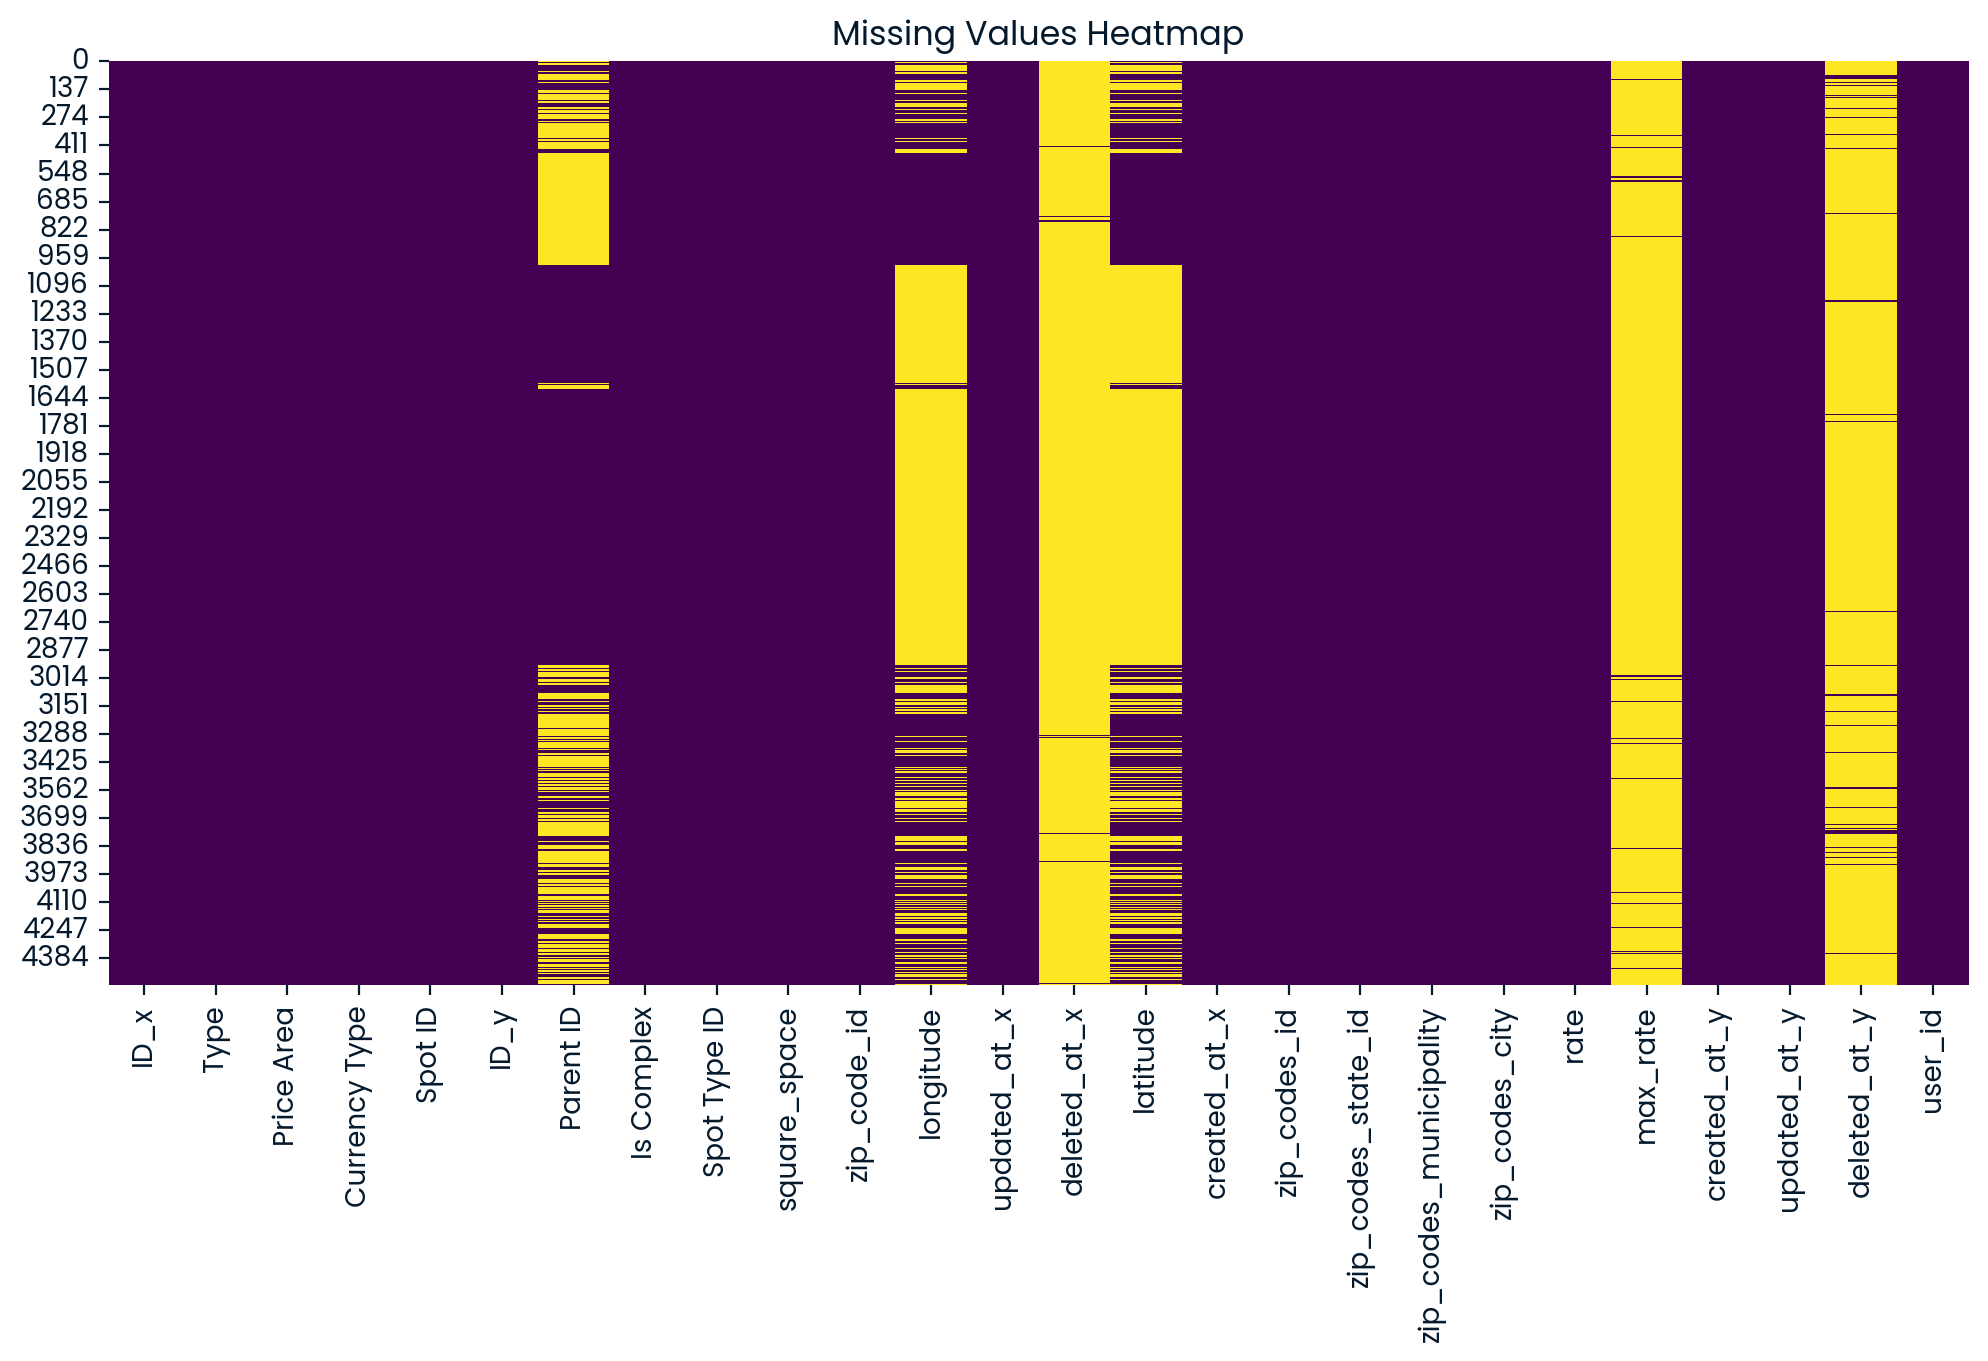

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display basic information about the dataframe
merged_df.info()

# Display basic statistics of the dataframe
merged_df.describe(include='all')

# Check for missing values
missing_values = merged_df.isnull().sum()

# Plotting missing values
plt.figure(figsize=(12, 6))
sns.heatmap(merged_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()


## Data Governance aspects:
Through this heatmap we find missing values. Let's make sure to always associate Longitude and Latitutde to each Spot ID to always have a specific location for each space. 

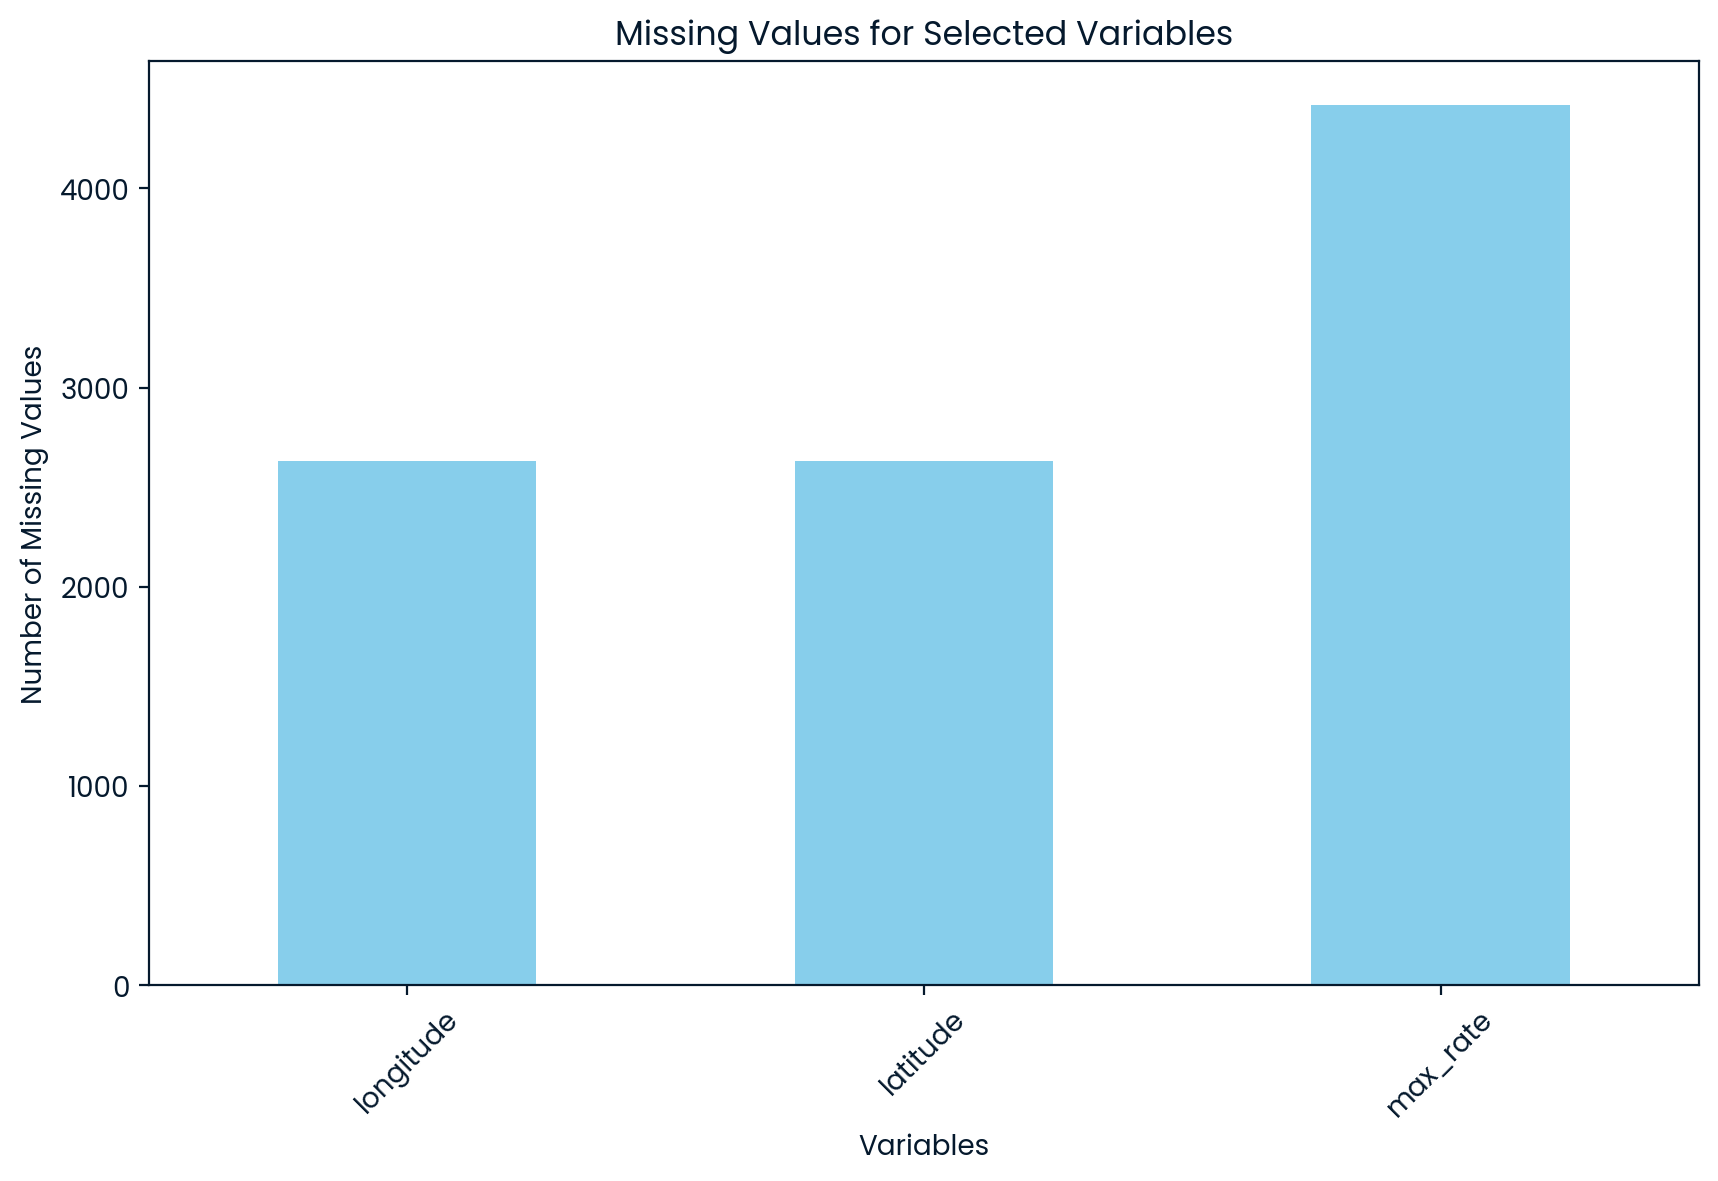

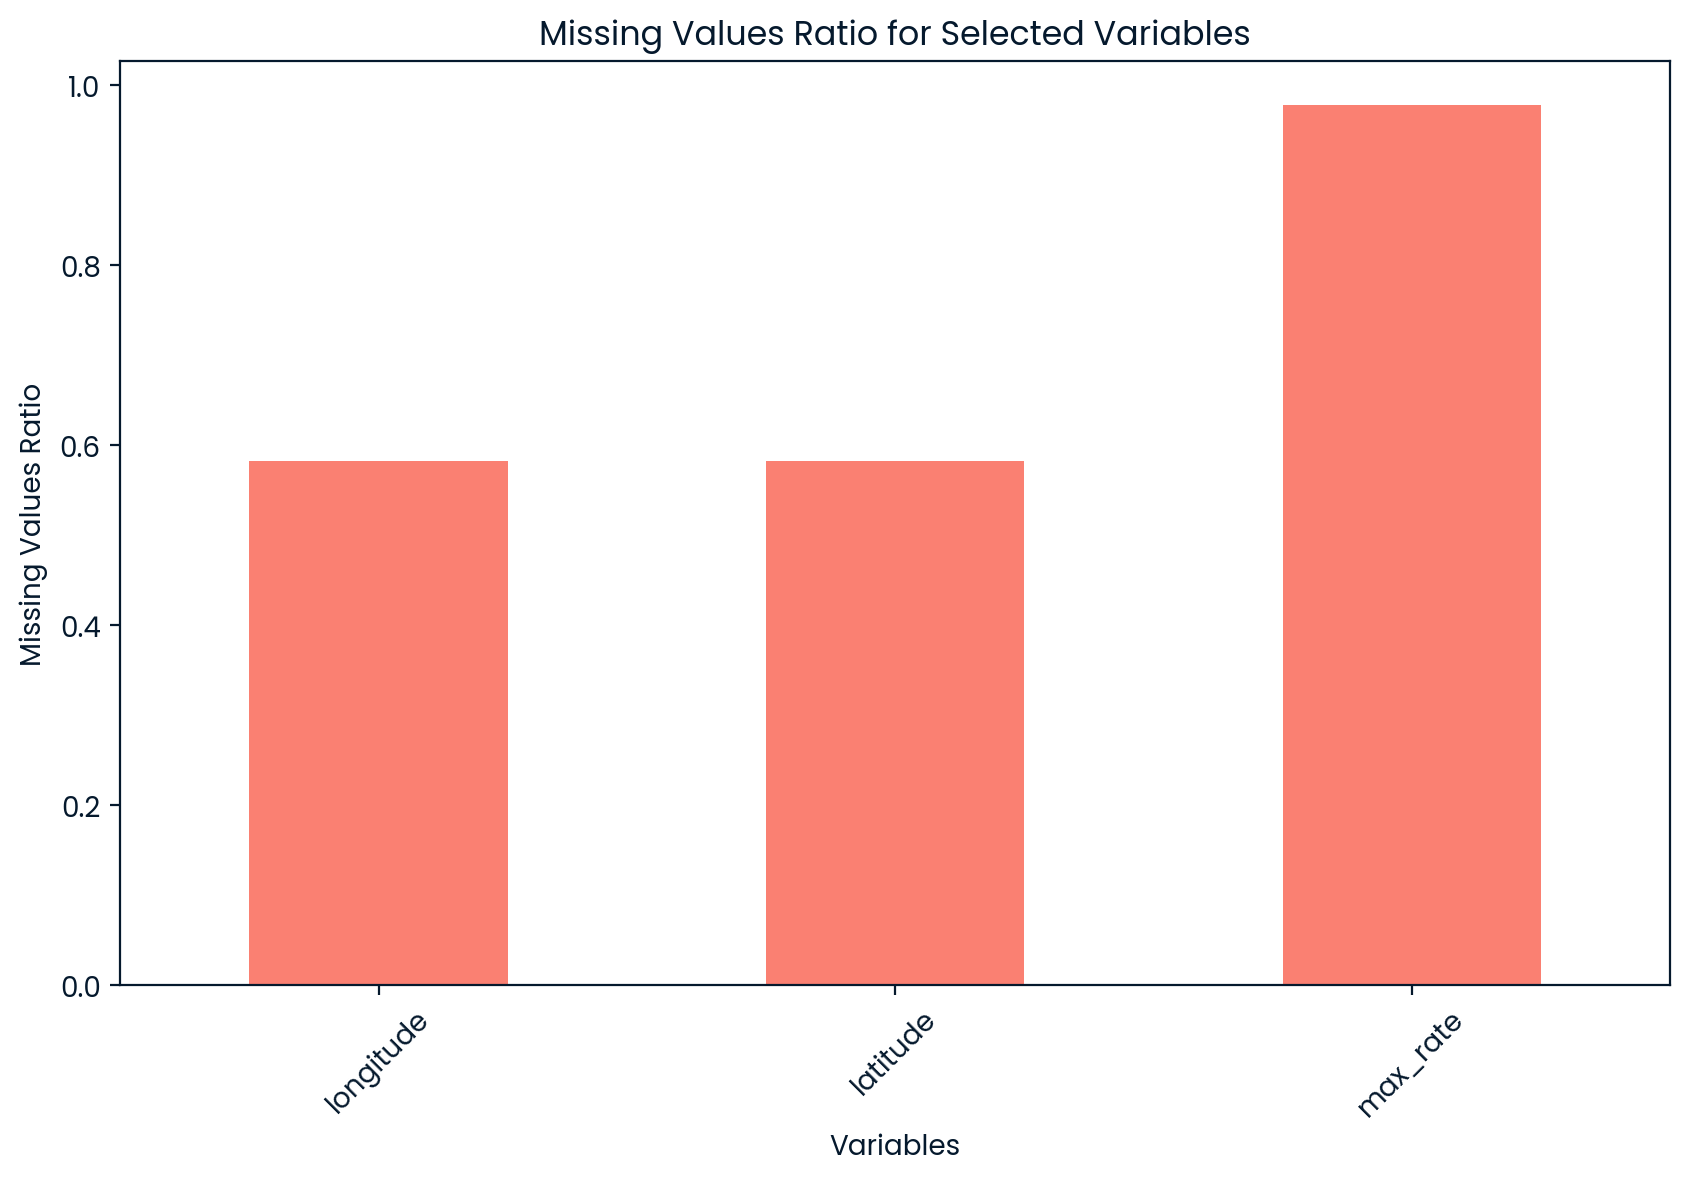

In [13]:
import matplotlib.pyplot as plt

# List of variables to check for missing values
variables = ["longitude", "latitude", "max_rate"]

# Calculate missing values for each variable
missing_values = merged_df[variables].isnull().sum()

# Calculate missing values ratio for each variable
missing_ratio = missing_values / len(merged_df)

# Plotting missing values
plt.figure(figsize=(10, 6))
missing_values.plot(kind='bar', color='skyblue')
plt.title('Missing Values for Selected Variables')
plt.xlabel('Variables')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45)
plt.show()

# Plotting missing values ratio
plt.figure(figsize=(10, 6))
missing_ratio.plot(kind='bar', color='salmon')
plt.title('Missing Values Ratio for Selected Variables')
plt.xlabel('Variables')
plt.ylabel('Missing Values Ratio')
plt.xticks(rotation=45)
plt.show()

# Calculate total missing values and ratio for all rows and IDs
total_missing_values = merged_df.isnull().sum().sum()
total_rows = len(merged_df)
total_ids = merged_df['Spot ID'].nunique()
missing_ratio_total = total_missing_values / (total_rows * len(merged_df.columns))



# Data Governance principles for readability. 
In order to make data useful for all Business Owners and for self-servicing purposes, it is always important to create a data dictionnary and metadata processes, such as the one below, adding readable information for reporting and use. Below you will find that it is easy to read that one row from one Spot ID is associated to an empty lot or field, or Industrial space for example. 

# Data Governance concerns
Here, it would be easy to generate some Data metrics such as readability, data standardization, data accuracy, data completeness(case of latitude and longitude, probably using imputations or interpolation if necessary depending on the case). 
Data transformations: those transformations assure data is readable and exploitable for future purposes(longitude and latitude or in some cases commas that need to be modified)
Data Relevance: How relevant is to add some variables, for example "deleted_at_x or y" are these variables relevant or need additional explanation from those stakeholders to make it useful.
Data Quality: Are there any anomalies in the variables? These anomalies need to be validated with the stakeholder or domain owner to correct and transform the data to make it useful. 

In [16]:
# Create the 'type_of_space' column based on the given conditions
merged_df['type_of_space'] = merged_df.apply(
    lambda row: 'individual_space' if pd.isnull(row['Parent ID']) and row['Is Complex'] == 0 else
                'multi_tenant' if row['Is Complex'] == 1 else
                'sub_space' if pd.notnull(row['Parent ID']) and row['Is Complex'] == 0 else
                None, axis=1)

# Create the 'space_category' column based on the 'Spot Type ID'
merged_df['space_category'] = merged_df['Spot Type ID'].map({
    13: 'Retail/Commercial',
    11: 'Office',
    9: 'Industrial',
    15: 'Field'
})


merged_df.to_csv('data.csv', index=False)
merged_df.head()




,ID_x,Type,Price Area,Currency Type,Spot ID,ID_y,Parent ID,Is Complex,Spot Type ID,square_space,zip_code_id,longitude,updated_at_x,deleted_at_x,latitude,created_at_x,zip_codes_id,zip_codes_state_id,zip_codes_municipality,zip_codes_city,rate,max_rate,created_at_y,updated_at_y,deleted_at_y,user_id,type_of_space,space_category
0,19625,1,2,1,22536,22536,None,0,9,5134.0,67634,99.222683,2024-02-01 11:14:00,NaT,19.469959,2024-02-01 11:14:00,67634,15,Naucalpan de Juárez,Naucalpan de Juárez,260.0,NaN,2024-02-01 11:14:00,2024-03-19 20:48:00,NaT,8524,individual_space,Industrial
1,19626,1,2,2,22537,22537,None,1,11,1121.0,29150,99.188542,2024-02-01 11:58:00,NaT,19.432164,2024-02-01 11:47:00,29150,7,Miguel Hidalgo,Ciudad de México,30.0,NaN,2024-02-01 11:47:00,2024-04-17 23:24:00,NaT,9541,multi_tenant,Office
2,19627,1,2,2,22538,22538,None,1,11,3950.0,29150,99.186012,2024-02-01 14:17:00,NaT,19.431947,2024-02-01 11:52:00,29150,7,Miguel Hidalgo,Ciudad de México,29.0,NaN,2024-02-01 11:52:00,2024-04-17 23:24:00,NaT,9541,multi_tenant,Office
3,19628,1,2,2,22539,22539,"22,538",0,11,1050.0,0,NaN,2024-02-01 11:54:00,NaT,NaN,2024-02-01 11:54:00,0,0,None,None,29.0,NaN,2024-02-01 11:54:00,2024-04-17 23:24:00,NaT,9541,sub_space,Office
4,19629,1,1,2,22540,22540,"22,538",0,11,2344.0,0,NaN,2024-02-01 11:54:00,NaT,NaN,2024-02-01 11:54:00,0,0,None,None,29.0,NaN,2024-02-01 11:54:00,2024-04-17 23:24:00,NaT,9541,sub_space,Office


# In order to check anomalies or outliers, i am going to check variables related to Square space vs space_category using logaritmic scale. 

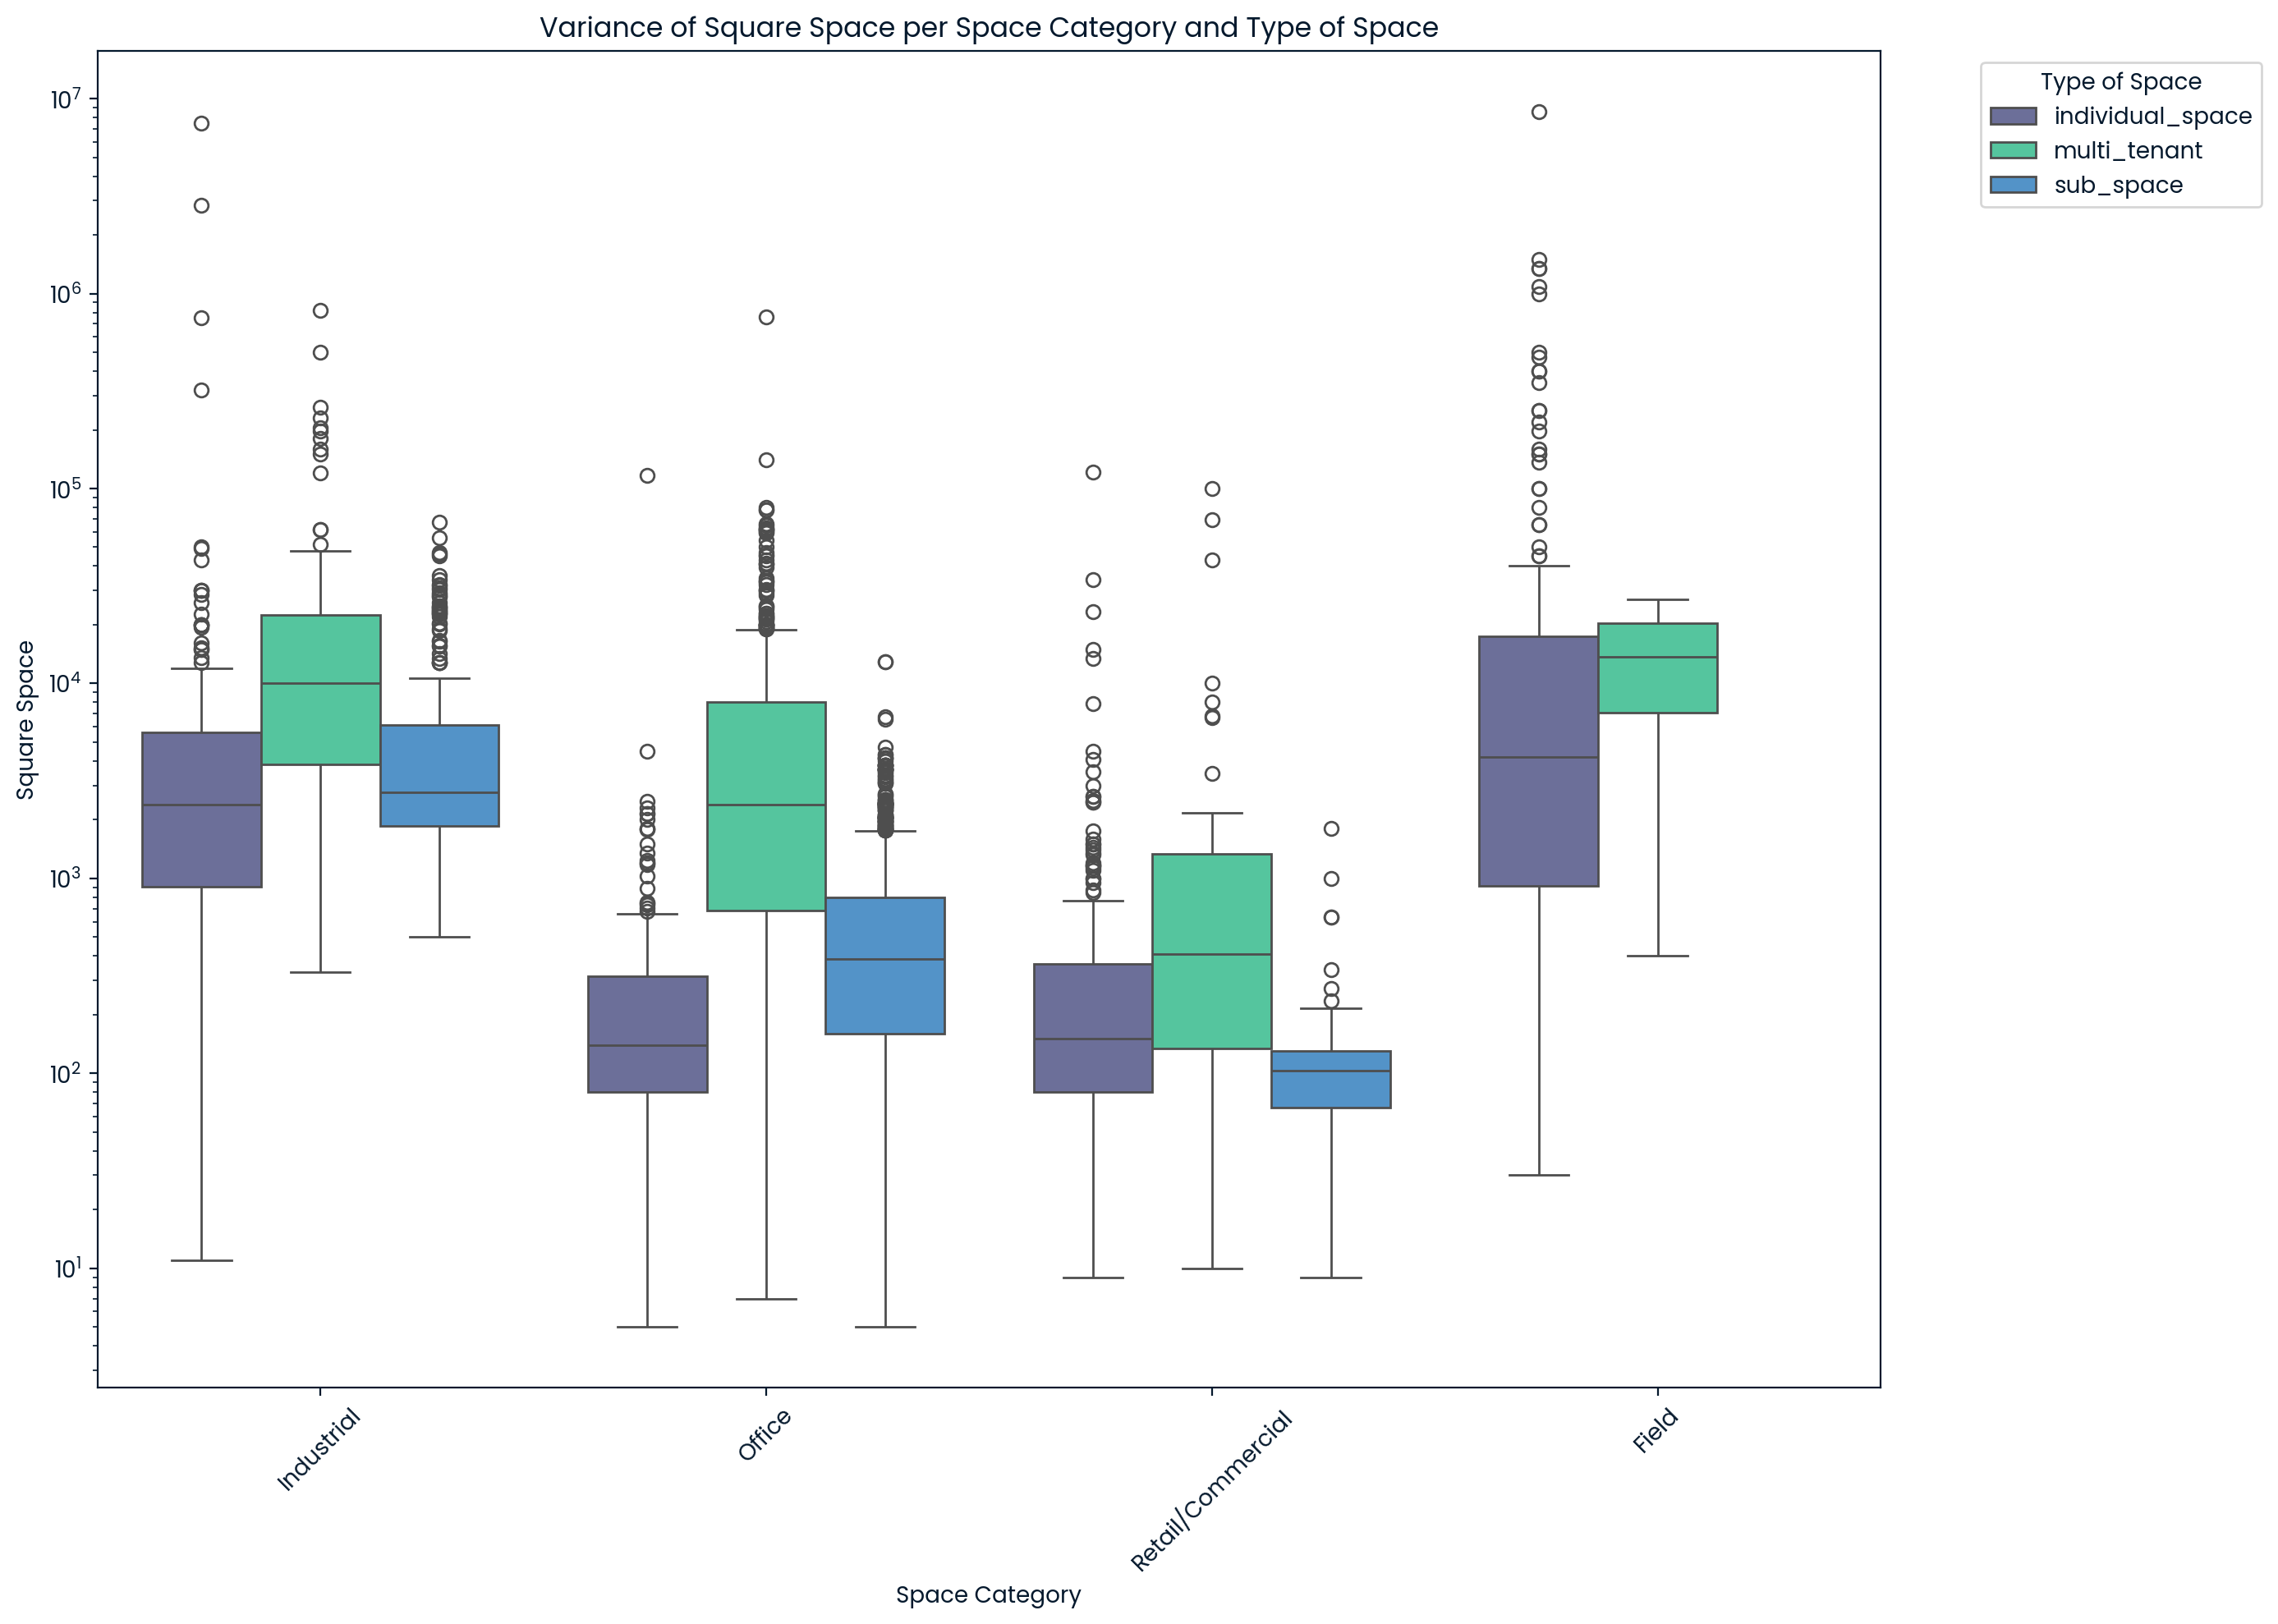

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a pivot table showing the average of 'Square Space' per 'space_category' and 'type_of_space'
pivot_table = merged_df.pivot_table(
    values='square_space', 
    index='space_category', 
    columns='type_of_space', 
    aggfunc='mean'
)

# Display the pivot table
pivot_table

# Create a box plot to show the variance of 'Square Space' per 'space_category' and 'type_of_space'
plt.figure(figsize=(14, 10))
sns.boxplot(x='space_category', y='square_space', hue='type_of_space', data=merged_df)
plt.title('Variance of Square Space per Space Category and Type of Space')
plt.xlabel('Space Category')
plt.ylabel('Square Space')
plt.yscale('log')  # Change the scale to logarithmic to make it easier to read
plt.legend(title='Type of Space', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# After checking all categories, i can see there are some outliers, it will be important to check their validity with domain owners to then adapt and adjust the data if necessary.